<a href="https://colab.research.google.com/github/ShotaSasaki-HU/ASTRO-CAMP-2025/blob/main/sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリ

In [184]:
import pandas as pd
import numpy as np
import statsmodels
import datetime as dt
import ee
from tqdm import tqdm # 進捗表示用
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install japanize-matplotlib
import japanize_matplotlib


# データ準備

## 目的変数（誘殺数）

### 5年間の時系列化

In [173]:
all_years = []

for year in range(2020, 2024 + 1):
    # セジロウンカ
    path = f"https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/%E9%A6%99%E5%B7%9D%E7%9C%8C%E8%BE%B2%E6%A5%AD%E8%A9%A6%E9%A8%93%E5%A0%B4%E7%97%85%E5%AE%B3%E8%99%AB%E9%98%B2%E9%99%A4%E6%89%80_%E6%A5%AD%E5%8B%99%E5%B9%B4%E5%A0%B1_%E5%90%84%E3%82%A4%E3%83%8D%E3%82%A6%E3%83%B3%E3%82%AB%E9%A1%9E%E3%81%AE%E6%97%A5%E5%88%A5%E8%AA%98%E6%AE%BA%E6%95%B0/%E3%82%BB%E3%82%B8%E3%83%AD%E3%82%A6%E3%83%B3%E3%82%AB%E6%97%A5%E5%88%A5%E8%AA%98%E6%AE%BA%E6%95%B0_{year}.csv"
    df_year = pd.read_csv(path, encoding="utf-8", header=0)
    df_year.drop('Unnamed: 0', axis=1, inplace=True)

    # 「欠測」を0と見做す
    df_year.replace('欠測', 0, inplace=True)

    # メスとオスの和
    for month in range(4, 11 + 1):
        df_year[f'{month}月'] = df_year[f'{month}月_メス'].astype('float64') + df_year[f'{month}月_オス'].astype('float64') # NaNを扱うためにfloat
        df_year.drop([f'{month}月_メス', f'{month}月_オス'], axis=1, inplace=True)

    # 縦持ちへ変換
    df_year = df_year.melt(
        id_vars=['日'], # そのまま残る列
        value_vars=['4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月'], # 値となる列
        var_name='月', # 新しい列名
        value_name='kill_score'
        )

    # 「西向く侍」のNaN値を排除
    df_year.dropna(inplace=True)

    # '月'を数値化
    df_year['月'] = df_year['月'].str.replace('月', '').astype(int)

    # datetime生成
    df_year['date'] = pd.to_datetime({
        'year': year,
        'month': df_year['月'],
        'day': df_year['日'].astype(int)
    }, errors='raise')
    df_year = df_year.sort_values('date').reset_index(drop=True) # 時系列順にソート

    df_year = df_year[['date', 'kill_score']]
    all_years.append(df_year)

# 5年分を結合
df_resp = pd.concat(all_years, ignore_index=True)
df_resp['kill_score'] = df_resp['kill_score'].astype(int)

print(df_resp)


           date  kill_score
0    2020-04-01           0
1    2020-04-02           0
2    2020-04-03           0
3    2020-04-04           0
4    2020-04-05           0
...         ...         ...
1215 2024-11-26           0
1216 2024-11-27           0
1217 2024-11-28           0
1218 2024-11-29           0
1219 2024-11-30           0

[1220 rows x 2 columns]


### 月半旬（5日ごと）でグループ化
pandas.DataFrame.resampleを使う手もある．

In [174]:
df_resp['year'] = df_resp['date'].dt.year
df_resp['month'] = df_resp['date'].dt.month
df_resp['day'] = df_resp['date'].dt.day

df_resp['hanjun'] = pd.cut(
    df_resp['day'],
    bins=[0, 5, 10, 15, 20, 25, 31], # 区切り
    labels=[1, 6, 11, 16, 21, 26]    # 月半旬開始日
)

df_resp['hanjun_start'] = pd.to_datetime({
    'year': df_resp['year'],
    'month': df_resp['month'],
    'day': df_resp['hanjun']
}, errors='raise')
df_resp = df_resp.sort_values('hanjun_start').reset_index(drop=True) # 時系列順にソート

df_resp = df_resp.groupby(['hanjun_start'], as_index=False)['kill_score'].sum()

print(df_resp)


    hanjun_start  kill_score
0     2020-04-01           0
1     2020-04-06           0
2     2020-04-11           0
3     2020-04-16           0
4     2020-04-21           0
..           ...         ...
235   2024-11-06           0
236   2024-11-11           0
237   2024-11-16           0
238   2024-11-21           0
239   2024-11-26           0

[240 rows x 2 columns]


## 説明変数

### Google Earth Engineの認証

In [175]:
ee.Authenticate() # Colabではブラウザで認証を行う
ee.Initialize(project='astro-camp')
# ee.Initialize(project='my-project-astrocamp')


### １．積算温度

#### CSV生成
CSVを作成済みの場合は，このセルをスキップする．

In [154]:
aoi = ee.Geometry.Rectangle([100, 15, 115, 30])
developmental_zero = 12.0 # 発育下限温度（発育零点）
PERIOD_DAYS = 5

# 指定された期間の積算温度を計算する関数
def get_degree_days_for_period(start_date, end_date):
    ee_start_date = ee.Date(start_date.strftime('%Y-%m-%d'))
    ee_end_date = ee.Date(end_date.strftime('%Y-%m-%d'))
    days_in_period = ee_end_date.difference(ee_start_date, 'day')

    # 指定した月半旬のMODIS画像コレクションを取得
    collection = ee.ImageCollection('MODIS/061/MOD11A1').filterDate(ee_start_date, ee_end_date)

    # --- ここからが積算温度の計算部分 ---

    # 期間内の画像枚数をサーバーサイドでカウント
    image_count = collection.size()

    # 画像が1枚以上ある場合の関数
    def calculate_stats(img_collection):
        # 日々の積算温度を計算する関数
        def calculate_degree_days(image):
            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．
            temp_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15)
            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．
            degree_day = temp_celsius.subtract(developmental_zero).max(0)
            return degree_day

        # コレクション内の各画像（各日）に対して上記の関数を適用
        daily_degree_days = collection.map(calculate_degree_days)

        # 期間内の日平均積算温度を計算し、期間の日数を掛けて正規化
        total_degree_days_image = daily_degree_days.mean().multiply(days_in_period).rename('Degree_Days')

        # AOI内の平均値を計算
        stats = total_degree_days_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        return stats

    # 画像が0枚だった場合の関数
    def empty_case():
        return ee.Dictionary({'Degree_Days': None})

    # image_count > 0 の条件で分岐を実行
    # ee.Algorithms.If(condition, true_case, false_case)
    # greater than(0)
    stats = ee.Dictionary(ee.Algorithms.If(image_count.gt(0), calculate_stats(collection), empty_case()))

    return stats.getInfo().get('Degree_Days')

lagged_features = [] # 遅延した特徴量たち
dd_cache = {} # 計算結果を保存するキャッシュ用の辞書

for index, row in tqdm(df_resp.iterrows(), total=df_resp.shape[0], desc="積算温度を計算中"):
    current_start = row['hanjun_start']

    row_features = {} # 計算結果を格納する辞書
    row_features['hanjun_start'] = current_start

    # 1半旬前から3半旬前までをループ処理
    for lag in range(1, 3 + 1):
        start_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * lag)
        end_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * (lag - 1))

        # キャッシュキーを作成
        cache_key = start_lag.strftime('%Y-%m-%d')

        # キャッシュの確認
        if cache_key in dd_cache:
            # キャッシュがある場合
            dd_value = dd_cache[cache_key]
        else:
            # キャッシュが無い場合
            dd_value = get_degree_days_for_period(start_lag, end_lag)
            dd_cache[cache_key] = dd_value

        row_features[f'積算温度_{lag}半旬前'] = dd_value

    lagged_features.append(row_features)

# 計算結果のリストを新しいデータフレームに変換
df_degree_days = pd.DataFrame(lagged_features)

# NaN値の線形補間を実行（月半旬が短いためデータが無い場合あり）
df_degree_days.interpolate(method='linear', inplace=True)

aoi_info = aoi.getInfo()
coords = aoi_info['coordinates'][0]
min_lon = coords[0][0]
min_lat = coords[0][1]
max_lon = coords[2][0]
max_lat = coords[2][1]
file_name = f"df_degree_days_[{min_lon}, {min_lat}, {max_lon}, {max_lat}].csv"
df_degree_days.to_csv(file_name)

df_degree_days


積算温度を計算中: 100%|██████████| 240/240 [01:46<00:00,  2.26it/s]


,hanjun_start,積算温度_1半旬前,積算温度_2半旬前,積算温度_3半旬前
0,2020-04-01,86.550977,75.531730,66.304770
1,2020-04-06,84.196312,86.550977,75.531730
2,2020-04-11,68.900737,84.196312,86.550977
3,2020-04-16,65.811132,68.900737,84.196312
4,2020-04-21,85.812071,65.811132,68.900737
...,...,...,...,...
235,2024-11-06,48.702089,47.952729,49.192877
236,2024-11-11,45.161967,48.702089,47.952729
237,2024-11-16,53.456676,45.161967,48.702089
238,2024-11-21,52.410584,53.456676,45.161967


#### CSV読み込み

In [176]:
path = "https://raw.githubusercontent.com/ShotaSasaki-HU/ASTRO-CAMP-2025/refs/heads/main/data/df_degree_days_%5B100%2C%2015%2C%20115%2C%2030%5D.csv"
df_degree_days = pd.read_csv(path, encoding="utf-8", header=0)
df_degree_days.drop('Unnamed: 0', axis=1, inplace=True)
df_degree_days['hanjun_start'] = pd.to_datetime(df_degree_days['hanjun_start'], errors="raise")

df_degree_days


,hanjun_start,積算温度_1半旬前,積算温度_2半旬前,積算温度_3半旬前
0,2020-04-01,86.550977,75.531730,66.304770
1,2020-04-06,84.196312,86.550977,75.531730
2,2020-04-11,68.900737,84.196312,86.550977
3,2020-04-16,65.811132,68.900737,84.196312
4,2020-04-21,85.812071,65.811132,68.900737
...,...,...,...,...
235,2024-11-06,48.702089,47.952729,49.192877
236,2024-11-11,45.161967,48.702089,47.952729
237,2024-11-16,53.456676,45.161967,48.702089
238,2024-11-21,52.410584,53.456676,45.161967


## 目的変数と説明変数の統合

In [177]:
# 正解データdf_respをベースにする．
df = df_resp.copy()

df = df.merge(df_degree_days, on='hanjun_start', how='left')

print(df)


    hanjun_start  kill_score  積算温度_1半旬前  積算温度_2半旬前  積算温度_3半旬前
0     2020-04-01           0  86.550977  75.531730  66.304770
1     2020-04-06           0  84.196312  86.550977  75.531730
2     2020-04-11           0  68.900737  84.196312  86.550977
3     2020-04-16           0  65.811132  68.900737  84.196312
4     2020-04-21           0  85.812071  65.811132  68.900737
..           ...         ...        ...        ...        ...
235   2024-11-06           0  48.702089  47.952729  49.192877
236   2024-11-11           0  45.161967  48.702089  47.952729
237   2024-11-16           0  53.456676  45.161967  48.702089
238   2024-11-21           0  52.410584  53.456676  45.161967
239   2024-11-26           0  40.296603  52.410584  53.456676

[240 rows x 5 columns]


### 冬の誘殺数を0埋めで生成（1月〜3月，12月）
★冬の体裁を整えなければならない理由は，まだ理解できていない．

冬の説明変数を取得すること自体は可能だが，今回は0埋めする．（アプローチB）

| アプローチ | 思想・目的 | モデルが学習すること | 長所 | 短所 |
| - | - | - | - | - |
| A：真の値を取得 | 「冬の環境」をありのままモデルに与える。 | ・「気温が5℃でNDVIが0.2の時は、誘殺数は0になる」という具体的な関係。<br>・冬の気象と「0」の間の強い相関。 | ・入力データが全て「真実」であるため、誠実なアプローチ。 | ・モデルが簡単な「冬=0」の予測に過剰適合し、夏の複雑な予測への学習が疎かになる恐れ（信号の希釈）。<br>・冬の各変数間の多重共線性も問題になりうる。 |
| B：0で埋める（推奨） | 「冬」という期間を「活動休止を示すベースライン=0」としてモデルに教える。 | ・「説明変数が全て0の時は、誘殺数は0になる」というシンプルなルール。<br>・説明変数が0から動き始めた時に、誘殺数がどう変化するか。 | ・モデルが「活動期」と「休止期」を明確に区別できる。<br>・各説明変数の係数が「活動期における影響度」をより純粋に表現するようになるため、モデルの解釈が容易になる。 | ・冬の期間の実際の気象データを捨てている。 |

> あなたのモデルの最終目的は、「冬の誘殺数が0であること」を当てることではなく、「夏の活動期間中の誘殺数の変動を、環境データからいかに正確に予測できるか」です。<br><br>
アプローチB（0埋め）は、モデルに対してこう伝えているのと同じです。<br>
「普段（冬）、全ての値は0です。これが平常状態です。しかし、春になり、積算温度やNDVIの値が0から増加し始めたら、注意してください。これらの値がどう動くかによって、夏の誘殺数が決まります。」<br><br>
つまり、説明変数を0埋めするのは、「冬の環境を正確に再現する」ことよりも、「モデルが夏の被害を予測するという本質的なタスクに集中できるような、理想的な入力データを作ってあげる」という目的を優先した、戦略的な判断なのです。<br><br>
これは時系列分析、特にオン/オフがはっきりしている季節性データを扱う際の、非常に一般的で効果的なテクニックです。

In [178]:
# 1. 2020〜2024年の全ての「月半旬」の日付リストを生成
full_hanjun_dates = []
for year in range(2020, 2025):
    for month in range(1, 13): # 1月〜12月
        for day in [1, 6, 11, 16, 21, 26]:
            full_hanjun_dates.append(pd.Timestamp(year=year, month=month, day=day))

# 2. 全ての日付を持つ「テンプレート」データフレームを作成
df_template = pd.DataFrame({'hanjun_start': full_hanjun_dates})

# 3. テンプレートに元のデータを結合（'left' join）
#   -> テンプレートの日付は全て残り、元のデータにない期間（冬）はNaNになる．
df = pd.merge(df_template, df, on='hanjun_start', how='left')

# 4. 全てのNaN値を0で埋める．
df = df.fillna(0)

df['kill_score'] = df['kill_score'].astype(int)
print(df)


    hanjun_start  kill_score  積算温度_1半旬前  積算温度_2半旬前  積算温度_3半旬前
0     2020-01-01           0        0.0        0.0        0.0
1     2020-01-06           0        0.0        0.0        0.0
2     2020-01-11           0        0.0        0.0        0.0
3     2020-01-16           0        0.0        0.0        0.0
4     2020-01-21           0        0.0        0.0        0.0
..           ...         ...        ...        ...        ...
355   2024-12-06           0        0.0        0.0        0.0
356   2024-12-11           0        0.0        0.0        0.0
357   2024-12-16           0        0.0        0.0        0.0
358   2024-12-21           0        0.0        0.0        0.0
359   2024-12-26           0        0.0        0.0        0.0

[360 rows x 5 columns]


### 誘殺数の原系列を可視化

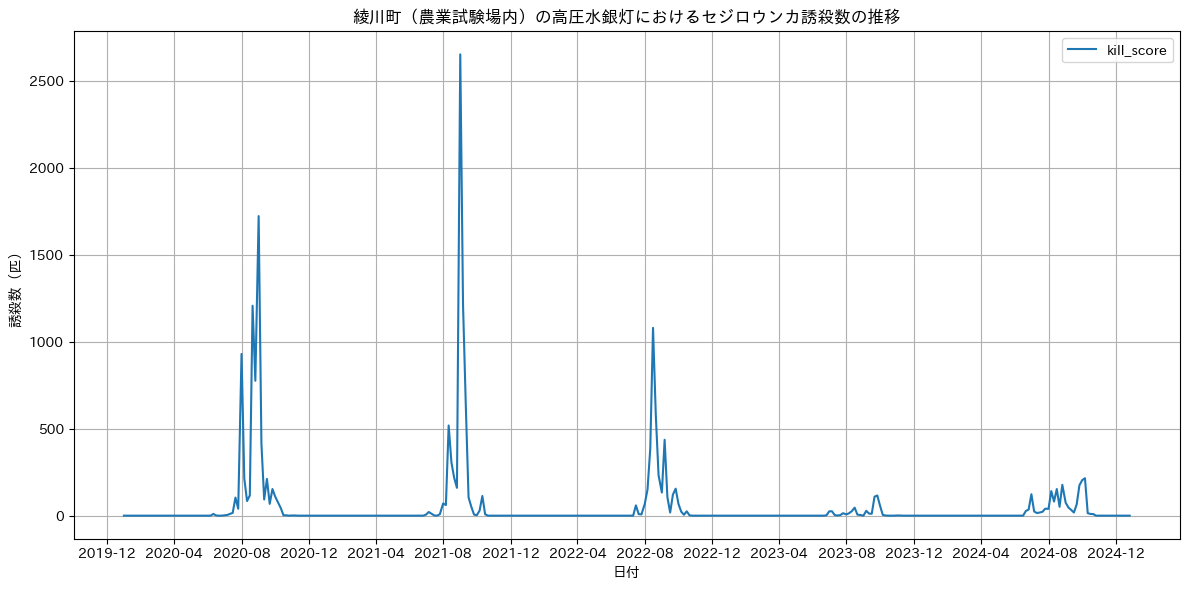

In [187]:
plt.figure(figsize=(12,6))
plt.plot(df["hanjun_start"], df["kill_score"], label="kill_score")

# 月ごとに目盛りを表示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # 4ヶ月ごと
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # YYYY-MM 表記

plt.title("綾川町（農業試験場内）の高圧水銀灯におけるセジロウンカ誘殺数の推移")
plt.xlabel("日付")
plt.ylabel("誘殺数（匹）")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# モデルの次数決定（パラメータ最適化）
SARIMAXモデルは (p,d,q)(P,D,Q,s) というパラメータを持ちます。これを統計的な指標を基に決定します。

- (p,d,q): 非季節性のトレンドに関するパラメータ (AR, I, MA)
- (P,D,Q,s): 季節性に関するパラメータ (Seasonal AR, I, MA, Period)
- s: 季節性の周期。週次データで1年の周期をみるので s=52 とします。

最適な組み合わせを見つけるために、**AIC（赤池情報量規準）**という指標が最も低いモデルを探すグリッドサーチを行います。